In [13]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2

In [17]:
TRAIN_PATH = 'data/full/train/'
IGNORE = ['.DS_Store']

train_images = []
train_labels = []

for label in os.listdir(TRAIN_PATH):
    if label in IGNORE:
        continue
    full_path = f'{TRAIN_PATH}/{label}'

    for filename in os.listdir(full_path):
        img = cv2.imread(os.path.join(full_path, filename))
        train_images.append(img)
        train_labels.append(label)

# Some EDA

## Image Examples

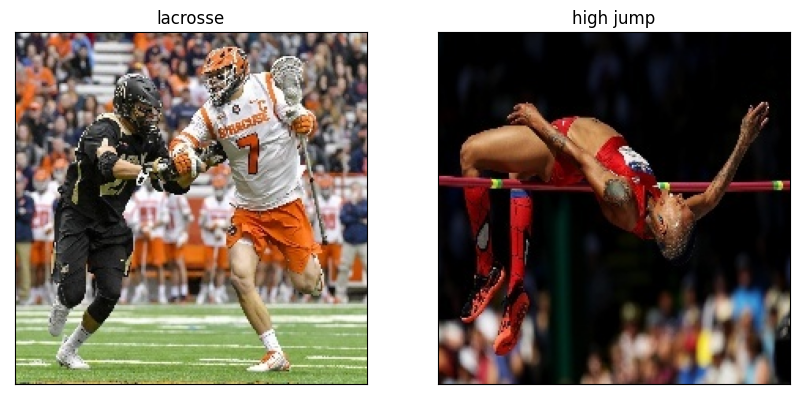

In [19]:
np.random.seed(9)
a, b, c, d = np.round(np.random.uniform(0, len(train_images), 4))

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(np.flip(train_images[int(a)], axis=-1))
axs[0].set_title(train_labels[int(a)])
axs[1].imshow(np.flip(train_images[int(b)], axis=-1))
axs[1].set_title(train_labels[int(b)])
axs[0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
axs[1].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# axs[1,0].imshow(np.flip(train_images[int(c)], axis=-1))
# axs[1,0].set_title(train_labels[int(c)])
# axs[1,1].imshow(np.flip(train_images[int(d)], axis=-1))
# axs[1,1].set_title(train_labels[int(d)]);


fig.savefig('Example_of_images.png')

## Filter Examples

In [2]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as T


plt.rcParams["savefig.bbox"] = 'tight'
orig_img = Image.open(Path('data/full/train/curling/') / '018.jpg')
torch.manual_seed(0)


def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False, figsize=(15, 15))
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original Image')
        axs[0, 0].title.set_size(15)
        axs[0, 1].set(title='HorizontalFlip')
        axs[0, 1].title.set_size(15)
        axs[0, 2].set(title='VerticalFlip')
        axs[0, 2].title.set_size(15)
        axs[0, 3].set(title='Equalize')
        axs[0, 3].title.set_size(15)
        axs[0, 4].set(title='Perspective')
        axs[0, 4].title.set_size(15)
        axs[0, 5].set(title='Autocontrast')
        axs[0, 5].title.set_size(15)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()
    fig.savefig('Augmentation.png')

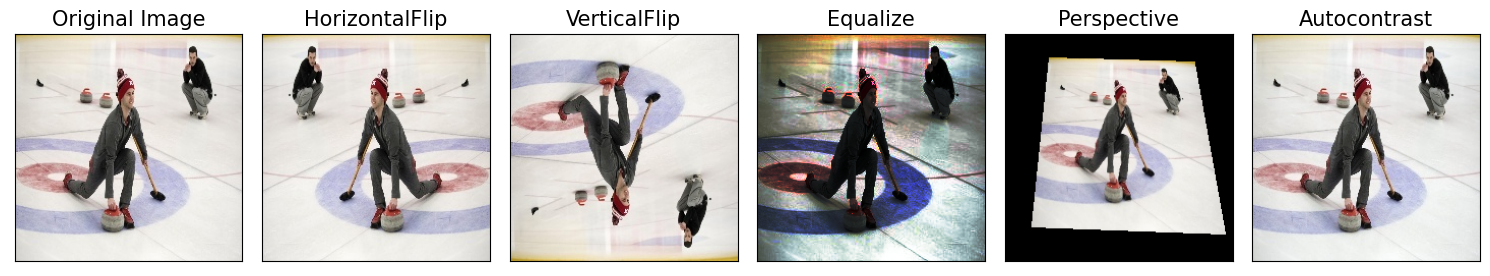

In [3]:
eq = T.RandomEqualize(p=1)
h_flip = T.RandomHorizontalFlip(p=1)
v_flip = T.RandomVerticalFlip(p=1)
pers = T.RandomPerspective(p=1, distortion_scale=0.4)
contrast = T.RandomAutocontrast(p=1)

all_filters = [h_flip, v_flip, eq, pers, contrast]

images = [custom_filter(orig_img) for _, custom_filter in zip(range(6), all_filters)]
plot(images, row_title=None)

## Training Visualization

In [234]:
data = pd.read_csv('remote_project/stat254/summary.csv', header=None)
data.columns = ['date', 'name', 'training_time', 'accuracy']

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

def get_logs(path, cls):
    all_files = glob.glob(os.path.join(path, cls))
    frames = []
    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        #df['model'] = filename.split('/')[-2]
        df['model'] = filename.split('/')[-2].split('_')[0]
        frames.append(df)
    return pd.concat(frames, axis=0, ignore_index=True)

In [41]:
path = 'remote_project/stat254/weights/'
cls = '*_native/*.csv'

data_native = get_logs(path, cls)

path = 'remote_project/stat254/weights/'
cls = '*_soft_aug/*.csv'

data_soft = get_logs(path, cls)

path = 'remote_project/stat254/weights/'
cls = '*_hard_aug/*.csv'

data_hard = get_logs(path, cls)

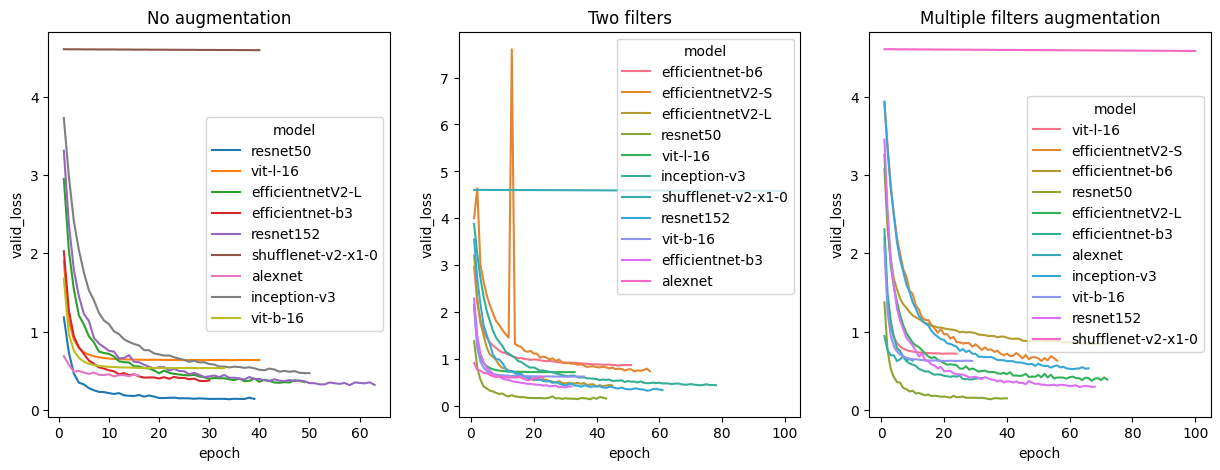

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

sns.lineplot(data=data_native, 
             x='epoch',
             y='valid_loss',
             hue='model',
             ax=ax[0])

sns.lineplot(data=data_soft, 
             x='epoch',
             y='valid_loss',
             hue='model',
             ax=ax[1])

sns.lineplot(data=data_hard, 
             x='epoch',
             y='valid_loss',
             hue='model',
             ax=ax[2])

ax[0].set_title('No augmentation')
ax[1].set_title('Two filters')
ax[2].set_title('Multiple filters augmentation');

# Blending

In [1]:
import time
import os

from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

class CNNClass():
    def __init__(self, model, transform, params, name,
                 path = 'data/full',
                 criterion = nn.CrossEntropyLoss(), 
                 optimizer = None,
                 device = 'cpu',
                 lr = 0.001):
        
        self.model = model
        self.transform = transform
        
        train_data = ImageFolder(f'{path}/train', transform=transform)
        valid_data = ImageFolder(f'{path}/valid', transform=transform)
        
        self.train_loader = DataLoader(train_data, batch_size=params['BATCH_SIZE'], shuffle=True, num_workers=2)
        self.valid_loader = DataLoader(valid_data, batch_size=params['BATCH_SIZE'], shuffle=True, num_workers=2)
        self.params = params
        self.name = name
        
        if not os.path.exists(f'weights/{self.name}'):
            os.mkdir(f'weights/{self.name}')

        self.criterion = criterion
        if optimizer == None:
            self.optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        else:
            self.optimizer = optimizer
        self.device = device
    
    def train(self):
        start_time = time.time()

        self.losses = {
            'train_loss': list(),
            'val_loss': list()
               }

        best_val_loss = float('inf')
        epoch_no_improvement = 0
        best_epoch = 1
        for epoch in range(self.params['EPOCHS']):
            running_loss = 0.0
            val_loss = 0.0
            self.model.train()
            for images, labels in self.train_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                output = self.model(images)
                loss = self.criterion(output, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item() * images.size(0)

            # Completed epoch, calculate validation error
            self.model.eval()
            with torch.no_grad():
                for images, labels in self.valid_loader:
                    images, labels = images.to(self.device), labels.to(self.device)
                    outputs = self.model(images)
                    loss = self.criterion(outputs, labels)
                    val_loss += loss.item() * images.size(0)

            epoch_loss = running_loss / len(self.train_loader.dataset)
            val_loss = val_loss / len(self.valid_loader.dataset)

            print(f'Epoch {epoch+1} Train loss: {epoch_loss:.3f}. Valid loss: {val_loss:.3f}')

            self.losses['train_loss'].append(epoch_loss)
            self.losses['val_loss'].append(val_loss)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_epoch = epoch + 1
                epoch_no_improvement = 0
                state = {'model': self.model.state_dict(), 
                         'optimizer': self.optimizer.state_dict()}
                torch.save(state, f'weights/{self.name}/{self.name}.pth')
            else:
                epoch_no_improvement += 1
                
            if epoch_no_improvement == self.params['EARLY_STOP']:
                print(f'Training completed! No improvement last {epoch_no_improvement} epoches.' +
                      f'\nBest valid accuracy: {best_val_loss:.2f}' +
                      f'\nBest epoch: {best_epoch}')
                self.train_time = "%s" % (time.time() - start_time)
                break
        
        self.train_time = "%s" % (time.time() - start_time)
        self.save_info()
        print('-'*10)
        print(f'Test Accuracy: {self.test():.2f}%')   
                
    def test(self, path='data/full/test', debug=False):
        test_data = ImageFolder(path, transform=self.transform)
        test_loader = DataLoader(test_data, batch_size=self.params['BATCH_SIZE'], shuffle=True, num_workers=2)

        self.model.load_state_dict(torch.load(f'weights/{self.name}/{self.name}.pth', 
                                              map_location=self.device)['model'])
        self.optimizer.load_state_dict(torch.load(f'weights/{self.name}/{self.name}.pth',
                                                  map_location=self.device)['optimizer'])

        correct = 0
        total = 0
        self.model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        return accuracy
    
    def save_info(self):
        # save time
        with open(f'weights/{self.name}/train_time.txt', 'w') as f:
            f.write(self.train_time)
        
        # save all stats
        with open(f'summary.csv', 'a') as f:
            f.write(f'{datetime.now().strftime("%d/%m/%Y %H:%M:%S")},{self.name},{self.train_time},{self.test()}\n')
        
        # save logs
        epoches = [i + 1 for i in range(len(self.losses['train_loss']))]
        with open(f'weights/{self.name}/accuracy_log.csv', 'w') as f:
            f.write("epoch,train_loss,valid_loss\n")
            for epoch, train_loss, valid_loss in zip(epoches, 
                                                     self.losses['train_loss'], 
                                                     self.losses['val_loss']):
                f.write(f"{epoch},{train_loss:.3f},{valid_loss:.3f}\n")
                
    def get_training_time(self):
        with open(f'weights/{self.name}/train_time.txt','r') as f:
            for line in f:
                print(np.round(float(line) / 60))
    
    def plot_accuracy(self):
        if os.path.exists(f'weights/{self.name}/accuracy_log.csv'):
            data = pd.read_csv(f'weights/{self.name}/accuracy_log.csv')
            fig, axs = plt.subplots(1, 1)
            axs.grid(alpha=0.4)
            axs.plot(data['epoch'],
                     data['train_loss'], label ='Train Loss', color='black')
            axs.plot(data['epoch'],
                     data['valid_loss'], label='Valid Loss', color='green')
            axs.legend()
            axs.set_xlabel('Epoch')
            axs.set_ylabel('Loss')
            axs.set_title(f'Loss for {self.name} model')
            return axs
        else:
            raise Exception(f'Missing weights/{self.name}/accuracy_log.csv')

In [3]:
from torchvision.models import alexnet, AlexNet_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = AlexNet_Weights.DEFAULT
model_sample = alexnet(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.classifier[-1] = nn.Linear(model_sample.classifier[-1].in_features,
                                        100)
model_sample.to(device_sample)

transform_sample = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model_params = {'BATCH_SIZE': 32,
                'EPOCHS': 50,
                'EARLY_STOP': 5}

model1 = CNNClass(model=model_sample,
                  transform=transform_sample,
                  params=model_params,
                  name='alexnet_native')

In [4]:
model1.test()

86.6

### Create 5 models to fetch their probs

# MODEL 1

In [2]:
from torchvision.models import alexnet, AlexNet_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = AlexNet_Weights.DEFAULT
model_sample = alexnet(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.classifier[-1] = nn.Linear(model_sample.classifier[-1].in_features,
                                        100)
model_sample.to(device_sample)

transform_sample = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model_params = {'BATCH_SIZE': 32,
                'EPOCHS': 100,
                'EARLY_STOP': 5}

model1 = CNNClass(model=model_sample,
                  transform=transform_sample,
                  params=model_params,
                  name='alexnet_native')

In [6]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader

class ImageFolderWithPaths(datasets.ImageFolder):
    def __getitem__(self, index):
        img, label = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]        
        return (img, label ,path)
    
test_data = ImageFolderWithPaths('data/full/test', transform=transform_sample)
test_loader = DataLoader(test_data, batch_size=1)

train_data = ImageFolderWithPaths('data/full/train', transform=transform_sample)
train_loader = DataLoader(train_data, batch_size=1)

valid_data = ImageFolderWithPaths('data/full/valid', transform=transform_sample)
valid_loader = DataLoader(valid_data, batch_size=1)

In [12]:
model1.model.load_state_dict(torch.load(f'weights/{model1.name}/{model1.name}.pth', 
                                        map_location='cpu')['model'])
model1.optimizer.load_state_dict(torch.load(f'weights/{model1.name}/{model1.name}.pth',
                                            map_location='cpu')['optimizer'])


# TEST LOADER
features = []
names = []
true_labels = []

model1.model.eval()
with torch.no_grad():
    for images, labels, name in test_loader:
        y_true = labels.copy_
        images, labels = images.to('cpu'), labels.to('cpu')
        outputs = model1.model(images)
        _, predicted = torch.max(outputs.data, 1)
        features.append(outputs.data.numpy()[0])
        names.append(name[0])
        true_labels.append(y_true)
        
model1_data_test = pd.DataFrame(features, index=names)
model1_data_test['class'] = true_labels


# TRAIN_LOADER
features = []
names = []
true_labels = []

model1.model.eval()
with torch.no_grad():
    for images, labels, name in train_loader:
        y_true = labels.copy_
        images, labels = images.to('cpu'), labels.to('cpu')
        outputs = model1.model(images)
        _, predicted = torch.max(outputs.data, 1)
        features.append(outputs.data.numpy()[0])
        names.append(name[0])
        true_labels.append(y_true)
        
model1_data_train = pd.DataFrame(features, index=names)
model1_data_train['class'] = true_labels
        
# VALID_LOADER
features = []
names = []
true_labels = []

model1.model.eval()
with torch.no_grad():
    for images, labels, name in valid_loader:
        y_true = labels.copy_
        images, labels = images.to('cpu'), labels.to('cpu')
        outputs = model1.model(images)
        _, predicted = torch.max(outputs.data, 1)
        features.append(outputs.data.numpy()[0])
        names.append(name[0])
        true_labels.append(y_true)

model1_data_valid = pd.DataFrame(features, index=names)
model1_data_valid['class'] = true_labels

ValueError: Length of values (14072) does not match length of index (13572)

In [11]:
full_data = pd.concat([model1_data_valid, model1_data_test, model1_data_train])
full_data.to_csv('model1_outputs.csv')

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
data/full/valid/air hockey/1.jpg,15.891971,-2.646993,-0.642561,-0.899438,-1.987824,6.775193,-0.965285,3.928868,4.292109,1.192915,...,1.363642,-1.179366,3.340350,5.179653,-1.881588,-1.523595,-2.219963,-0.362246,-2.940706,-2.043370
data/full/valid/air hockey/2.jpg,12.150693,0.888304,1.211040,4.147930,0.362218,4.479301,-0.752531,1.141235,4.035693,5.227070,...,1.561880,0.813179,3.573091,5.738778,-0.870499,-0.922223,-1.459048,-1.131854,-0.548785,-2.353233
data/full/valid/air hockey/3.jpg,11.116868,-1.126416,1.957775,-0.304238,1.935698,3.222539,-1.380615,1.481935,0.971924,0.882738,...,2.655254,-1.796688,2.318489,-0.490032,0.388110,-1.181839,1.016353,-1.844156,0.181062,1.938305
data/full/valid/air hockey/4.jpg,18.457186,-5.641372,-0.170827,-0.722448,-2.773939,0.585153,-3.493063,0.023329,2.708167,-0.916198,...,3.506579,-6.035542,2.848371,2.129636,-3.380532,-1.549139,0.970274,-1.553810,0.244585,-2.730266
data/full/valid/air hockey/5.jpg,8.056189,-2.135525,2.069335,1.554863,4.374400,3.161768,-0.291496,1.463387,0.509677,0.838012,...,-0.275289,-0.241579,1.422545,2.477027,0.293456,0.601534,4.636645,-1.137511,-1.072885,-2.546813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
data/full/train/wingsuit flying/94.jpg,-1.360260,4.398743,-0.596812,1.442377,0.627048,-3.822317,0.090451,-1.296955,-0.318178,0.815114,...,0.912356,-0.789454,-3.495735,0.576524,2.299105,-0.547899,-4.943852,-3.374749,-2.594322,17.859755
data/full/train/wingsuit flying/95.jpg,-2.438685,-2.040540,-6.287849,-0.071585,-4.638502,-1.770965,-0.369090,-0.353830,-2.836889,-1.269822,...,2.099237,1.445680,-1.975602,1.058291,4.439365,-1.518451,-2.876530,-4.232128,-0.935713,15.304527
data/full/train/wingsuit flying/96.jpg,-3.513275,-0.111569,3.239144,-1.895890,-0.085945,-2.676399,-4.666142,0.170173,-2.240391,2.067654,...,-1.706537,1.628710,-1.646940,0.683215,3.682097,0.383880,-1.053570,-1.745382,2.085340,14.735186
data/full/train/wingsuit flying/97.jpg,0.010294,1.523221,-3.634674,1.508986,0.708337,-4.168146,-1.165739,-0.657763,-2.291912,-1.618906,...,-0.323562,-1.286524,-3.276324,-1.000114,4.011617,0.685279,-0.392871,-1.630966,4.463183,16.533928


In [130]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader

class ImageFolderWithPaths(datasets.ImageFolder):
    def __getitem__(self, index):
        img, label = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]        
        return (img, label ,path)

test_data = ImageFolderWithPaths('data/full/test', transform=transform_sample)
test_loader = DataLoader(test_data, batch_size=1)

model1.model.load_state_dict(torch.load(f'weights/{model1.name}/{model1.name}.pth', 
                                      map_location='cpu')['model'])
model1.optimizer.load_state_dict(torch.load(f'weights/{model1.name}/{model1.name}.pth',
                                          map_location='cpu')['optimizer'])


features = []
names = []

correct = 0
total = 0
model1.model.eval()
with torch.no_grad():
    for images, labels, name in test_loader:
        y_true = labels.copy_
        images, labels = images.to('cpu'), labels.to('cpu')
        outputs = model1.model(images)
        _, predicted = torch.max(outputs.data, 1)
        features.append(outputs.data.numpy()[0])
        names.append(name[0])
        
model1_data_test = pd.DataFrame(features, index=names)

# MODEL 2

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ResNet50_Weights.DEFAULT
model_sample = resnet50(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.fc = nn.Linear(model_sample.fc.in_features, 100)

model_sample.to(device_sample)

transform_sample = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model2 = CNNClass(model=model_sample,
                  transform=transform_sample,
                  params=model_params,
                  optimizer = optim.Adam(model_sample.parameters(), lr=0.0005),
                  name='resnet50_native')

# MODEL 3

In [ ]:
from torchvision.models import inception_v3, Inception_V3_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = Inception_V3_Weights.DEFAULT
model_sample = inception_v3(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.fc = nn.Linear(model_sample.fc.in_features,
                      100)
model_sample.aux_logits=False
model_sample.to(device_sample)

transform_sample = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model3 = CNNClass(model=model_sample,
                  transform=transform_sample,
                  params=model_params,
                  name='inception-v3_native')

# MODEL 4

In [ ]:
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = EfficientNet_B3_Weights.DEFAULT
model_sample = efficientnet_b3(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1536, out_features=100)
)

model_sample.to(device_sample)

transform_sample = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model4 = CNNClass(model=model_sample,
                  transform=transform_sample,
                  params=model_params,
                  optimizer = optim.Adam(model_sample.parameters(), lr=0.0005),
                  name='efficientnet-b3_native')

# MODEL 5

In [ ]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ViT_B_16_Weights.DEFAULT
model_sample = vit_b_16(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.heads.head = nn.Linear(model_sample.heads.head.in_features, 100)

model_sample.to(device_sample)

transform_sample = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model5 = CNNClass(model=model_sample,
                  transform=transform_sample,
                  params=model_params,
                  optimizer = optim.SGD(model_sample.parameters(), lr=0.001, momentum=0.9, weight_decay=0.03),
                  name='vit-b-16_native')

In [115]:
list(outputs.data.numpy()[0])

[0.41538242,
 3.8171833,
 -2.342504,
 0.97851086,
 -0.37518895,
 -3.7113101,
 -1.3048282,
 -0.4947676,
 -2.364205,
 -1.9021025,
 1.0460517,
 -1.0790268,
 0.55318844,
 2.0227084,
 -4.6084895,
 -0.288637,
 -1.0108232,
 6.446505,
 2.3956547,
 -2.287162,
 -3.2204332,
 -5.4233713,
 -0.54017967,
 1.2459592,
 0.24803217,
 -0.6034869,
 -1.6192344,
 -5.000164,
 -2.3080103,
 -4.107951,
 0.9136664,
 0.2214446,
 -2.147785,
 0.09066685,
 0.80710965,
 0.4015856,
 2.9950216,
 -2.4768872,
 7.8319693,
 0.118907064,
 -2.3460345,
 -1.5384227,
 2.6200275,
 1.1738374,
 1.5029668,
 -1.823045,
 1.6102772,
 5.1128573,
 -3.7666638,
 3.559516,
 -1.3837372,
 2.3234415,
 -4.574629,
 -0.95473963,
 1.3123151,
 0.08413471,
 0.7486007,
 2.3926818,
 -1.3559294,
 -4.6482773,
 -2.8231688,
 2.383697,
 -2.8224833,
 -2.4053519,
 0.0817931,
 1.0512654,
 -2.0780466,
 1.122011,
 0.54158884,
 -1.3432033,
 -1.6048943,
 -2.601828,
 1.9349127,
 2.073162,
 -1.5787901,
 0.29855663,
 1.6408116,
 4.9088173,
 3.486072,
 2.740274,
 2.2

In [57]:
model1.test()

86.6

In [28]:
model1.test()

86.6

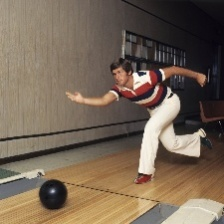

In [29]:
test_image